In [1]:
#---------------------------------------------------------------------------------------------------#
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import plotly.subplots as sp
import math
from pprint import pprint

from plotly.subplots import make_subplots
from scipy.stats import mode
from scipy.integrate import cumulative_trapezoid
from scipy.signal import correlate
import json
%config Completer.use_jedi = False  # Fixes autocomplete issues
%config InlineBackend.figure_format = 'retina'  # Improves plot resolution

import gc # garbage collector for removing large variables from memory instantly 
import importlib #for force updating changed packages 

#import harp
import harp_resources.process
import harp_resources.utils
from harp_resources import process, utils # Reassign to maintain direct references for force updating 

import seaborn as sns
import pickle
import warnings

warnings.filterwarnings('ignore')

In [2]:
#-------------------------------
# data paths setup
#-------------------------------
data_dirs = [  # Add your data directories here
    # Path('~/RANCZLAB-NAS/data/ONIX/20250409_Cohort3_rotation/Vestibular_mismatch_day1').expanduser(),
    # Path('/Volumes/RanczLab2/20241125_Cohort1_rotation/Visual_mismatch_day4').expanduser(),
    Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1').expanduser(),
]

# Collect raw data paths (excluding '_processedData' dirs)
rawdata_paths = []
for data_dir in data_dirs:
    subdirs = [p for p in data_dir.iterdir() if p.is_dir() and not p.name.endswith('_processedData')]
    rawdata_paths.extend(subdirs)  # Collect all subdirectories

# Build processed data paths
data_paths = [raw.parent / f"{raw.name}_processedData/aligned_data" for raw in rawdata_paths]
mouse_name = [raw.name.split('-')[0] for raw in rawdata_paths]
selected_mice = ["B6J2780", "B6J2781", "B6J2783"] #for cohort 3
# selected_mice = ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2720', 'B6J2721', 'B6J2722'] #for cohort 1


# Print data paths in a more readable format
print("Processed Data Paths:")
pprint(data_paths)
print("Mouse Name:")
pprint(mouse_name)

Processed Data Paths:
[PosixPath('/Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2780-2025-04-30T10-21-10_processedData/aligned_data'),
 PosixPath('/Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2781-2025-04-30T10-46-37_processedData/aligned_data'),
 PosixPath('/Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2782-2025-04-30T11-11-53_processedData/aligned_data'),
 PosixPath('/Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2783-2025-04-30T11-37-15_processedData/aligned_data')]
Mouse Name:
['B6J2780', 'B6J2781', 'B6J2782', 'B6J2783']


In [3]:
#-------------------------------
# load aligned_downsampled data for each data path
#-------------------------------
loaded_data = {}  # Dictionary to store loaded data for each path

for idx, data_path in enumerate(data_paths, start=1):
    print(f"\nProcessing data path {idx}/{len(data_paths)}: {data_path}")
    csv_file_path = data_path / f"{mouse_name[idx - 1]}_baselined_data.csv"
    aligned_df = pd.read_csv(csv_file_path)
        
    print(f"✅ Successfully loaded all data files for {data_path.name}")

    loaded_data[data_path] = {
        'mouse_name': mouse_name[idx - 1],
        'data_path': data_path
    }
    # Add each column of aligned_df as a separate key in the dictionary
    for column in aligned_df.columns:
        loaded_data[data_path][column] = aligned_df[column].values

    print(f"Data loaded for {data_path.name}: {len(aligned_df)} rows, {len(aligned_df.columns)} columns")


Processing data path 1/4: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2780-2025-04-30T10-21-10_processedData/aligned_data
✅ Successfully loaded all data files for aligned_data
Data loaded for aligned_data: 864054 rows, 27 columns

Processing data path 2/4: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2781-2025-04-30T10-46-37_processedData/aligned_data
✅ Successfully loaded all data files for aligned_data
Data loaded for aligned_data: 1440090 rows, 27 columns

Processing data path 3/4: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2782-2025-04-30T11-11-53_processedData/aligned_data
✅ Successfully loaded all data files for aligned_data
Data loaded for aligned_data: 1136071 rows, 27 columns

Processing data path 4/4: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/B6J2783-2025-04-30T11-37-15_processedData/aligned_data
✅ Successfully loaded all data files for aligned_data
Data loaded for aligned_data: 1424089 rows, 27 colum

In [4]:
#computes mean and sem per mouse + stores grand averages across all mice

def compute_mouse_means_and_grand_average(loaded_data, selected_columns, main_data_dir):
    """
    Compute means per mouse and grand averages across mice for selected columns.
    
    Parameters:
    loaded_data (dict): Dictionary with data paths as keys and mouse data as values
    selected_columns (list): List of column names to analyze
    main_data_dir (str/Path): Main directory to save results
    
    Returns:
    tuple: (mean_data_per_mouse, sem_data_per_mouse, grand_averages)
    """
    
    main_data_dir = Path(main_data_dir)
    
    print(f"Processing selected columns: {selected_columns}")
    
    # Step 1: Compute mean and SEM for each mouse
    mean_data_per_mouse = {}
    sem_data_per_mouse = {}
    
    for data_path, data in loaded_data.items():
        mouse_name = data['mouse_name']
        print(f"Processing mouse: {mouse_name}")
        
        # Create DataFrame from the loaded data
        df = pd.DataFrame(data)
        
        # Check which selected columns are available
        available_columns = [col for col in selected_columns if col in df.columns]
        missing_columns = [col for col in selected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"⚠️  Missing columns for {mouse_name}: {missing_columns}")
        
        if 'Time (s)' not in df.columns:
            print(f"⚠️  'Time (s)' column not found for {mouse_name}, skipping...")
            continue
        
        # Group by time and compute mean and SEM
        grouped = df.groupby('Time (s)')
        
        # Only use numeric columns that are in our selected list
        numeric_selected = []
        for col in available_columns:
            if col != 'Time (s)' and pd.api.types.is_numeric_dtype(df[col]):
                numeric_selected.append(col)
        
        if len(numeric_selected) == 0:
            print(f"⚠️  No numeric columns found for {mouse_name}")
            continue
        
        mean_data_per_mouse[mouse_name] = grouped[numeric_selected].mean()
        sem_data_per_mouse[mouse_name] = grouped[numeric_selected].sem()
        
        print(f"✅ Processed {len(numeric_selected)} columns for {mouse_name}")
    
    # Step 2: Compute grand averages across mice
    print(f"\n📊 Computing grand averages across {len(mean_data_per_mouse)} mice...")
    
    # Get all unique time points
    all_time_points = set()
    for mouse_data in mean_data_per_mouse.values():
        all_time_points.update(mouse_data.index)
    all_time_points = sorted(list(all_time_points))
    
    # Get all columns that were successfully processed
    all_processed_columns = set()
    for mouse_data in mean_data_per_mouse.values():
        all_processed_columns.update(mouse_data.columns)
    all_processed_columns = sorted(list(all_processed_columns))
    
    print(f"Time points: {len(all_time_points)} from {min(all_time_points):.2f}s to {max(all_time_points):.2f}s")
    print(f"Processed columns: {all_processed_columns}")
    
    # Create grand average DataFrame
    grand_averages = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_averages.index.name = 'Time (s)'
    
    grand_sems = pd.DataFrame(index=all_time_points, columns=all_processed_columns)
    grand_sems.index.name = 'Time (s)'
    
    # Compute grand averages for each column and time point
    for col in all_processed_columns:
        for time_point in all_time_points:
            # Collect data from all mice for this time point and column
            mouse_values = []
            for mouse_name, mouse_data in mean_data_per_mouse.items():
                if time_point in mouse_data.index and col in mouse_data.columns:
                    value = mouse_data.loc[time_point, col]
                    if not pd.isna(value):
                        mouse_values.append(value)
            
            if len(mouse_values) > 0:
                grand_averages.loc[time_point, col] = np.mean(mouse_values)
                if len(mouse_values) > 1:
                    grand_sems.loc[time_point, col] = np.std(mouse_values) / np.sqrt(len(mouse_values))
                else:
                    grand_sems.loc[time_point, col] = 0
    
    # # Step 3: Save grand averages to CSV
    # csv_filename = main_data_dir / f'grand_averages_across_mice_{main_data_dir.name}.csv'
    # # Combine mean and SEM into one CSV for convenience
    # combined_df = grand_averages.copy()
    # for col in all_processed_columns:
    #     combined_df[f'{col}_SEM'] = grand_sems[col]
    
    # combined_df.to_csv(csv_filename)
    # print(f"✅ Grand averages saved to: {csv_filename}")
    
    return mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems

def analyze_mice_data(loaded_data, selected_columns, main_data_dir):
    """
    Complete analysis workflow: compute means, grand averages, save CSV, and create plots.
    
    Parameters:
    loaded_data (dict): Your loaded_data dictionary
    selected_columns (list): List of column names to analyze (including 'Time (s)')
    main_data_dir (str/Path): Main directory to save results
    
    Returns:
    dict: Complete results including individual and grand averages
    """
    
    print(f"\n{'='*60}")
    print(f"MOUSE DATA ANALYSIS")
    print(f"{'='*60}")
    
    # Compute means and grand averages
    mean_data_per_mouse, sem_data_per_mouse, grand_averages, grand_sems = compute_mouse_means_and_grand_average(
        loaded_data, selected_columns, main_data_dir
    )
    

    # Print summary
    print(f"\n📊 ANALYSIS COMPLETE:")
    print(f"   • Number of mice analyzed: {len(mean_data_per_mouse)}")
    print(f"   • Mouse names: {list(mean_data_per_mouse.keys())}")
    print(f"   • Columns processed: {list(grand_averages.columns)}")
    print(f"   • Time range: {grand_averages.index.min():.2f}s to {grand_averages.index.max():.2f}s")
    print(f"   • Files saved in: {main_data_dir}")
    
    # Return all results
    results = {
        'mean_data_per_mouse': mean_data_per_mouse,
        'sem_data_per_mouse': sem_data_per_mouse,
        'grand_averages': grand_averages,
        'grand_sems': grand_sems,
    }
    
    return results

# Example usage with your data:
print("🔬 Mouse Data Analysis Ready!")
print("\nTo run your analysis:")
print("selected_columns = ['Time (s)', 'Velocity_0Y_Baseline', 'Motor_Velocity_Baseline', 'z_470_Baseline', 'z_560_Baseline']")
print("main_data_dir = Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4')")
print("results = analyze_mice_data(loaded_data, selected_columns, main_data_dir)")

🔬 Mouse Data Analysis Ready!

To run your analysis:
selected_columns = ['Time (s)', 'Velocity_0Y_Baseline', 'Motor_Velocity_Baseline', 'z_470_Baseline', 'z_560_Baseline']
main_data_dir = Path('/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4')
results = analyze_mice_data(loaded_data, selected_columns, main_data_dir)


In [5]:
selected_columns = ['Time (s)', 'Velocity_0Y_Baseline', 'Motor_Velocity_Baseline', 'z_470_Baseline', 'z_560_Baseline', 'Velocity_0X_Baseline']
main_data_dir = data_dirs[0]  # Use the first directory from the list

# Run the complete analysis
results = analyze_mice_data(loaded_data, selected_columns, main_data_dir)


MOUSE DATA ANALYSIS
Processing selected columns: ['Time (s)', 'Velocity_0Y_Baseline', 'Motor_Velocity_Baseline', 'z_470_Baseline', 'z_560_Baseline', 'Velocity_0X_Baseline']
Processing mouse: B6J2780
✅ Processed 5 columns for B6J2780
Processing mouse: B6J2781
✅ Processed 5 columns for B6J2781
Processing mouse: B6J2782
✅ Processed 5 columns for B6J2782
Processing mouse: B6J2783
✅ Processed 5 columns for B6J2783

📊 Computing grand averages across 4 mice...
Time points: 16001 from -6.00s to 10.00s
Processed columns: ['Motor_Velocity_Baseline', 'Velocity_0X_Baseline', 'Velocity_0Y_Baseline', 'z_470_Baseline', 'z_560_Baseline']

📊 ANALYSIS COMPLETE:
   • Number of mice analyzed: 4
   • Mouse names: ['B6J2780', 'B6J2781', 'B6J2782', 'B6J2783']
   • Columns processed: ['Motor_Velocity_Baseline', 'Velocity_0X_Baseline', 'Velocity_0Y_Baseline', 'z_470_Baseline', 'z_560_Baseline']
   • Time range: -6.00s to 10.00s
   • Files saved in: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1


Plot saved to: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/z_470_Baseline_plot.pdf


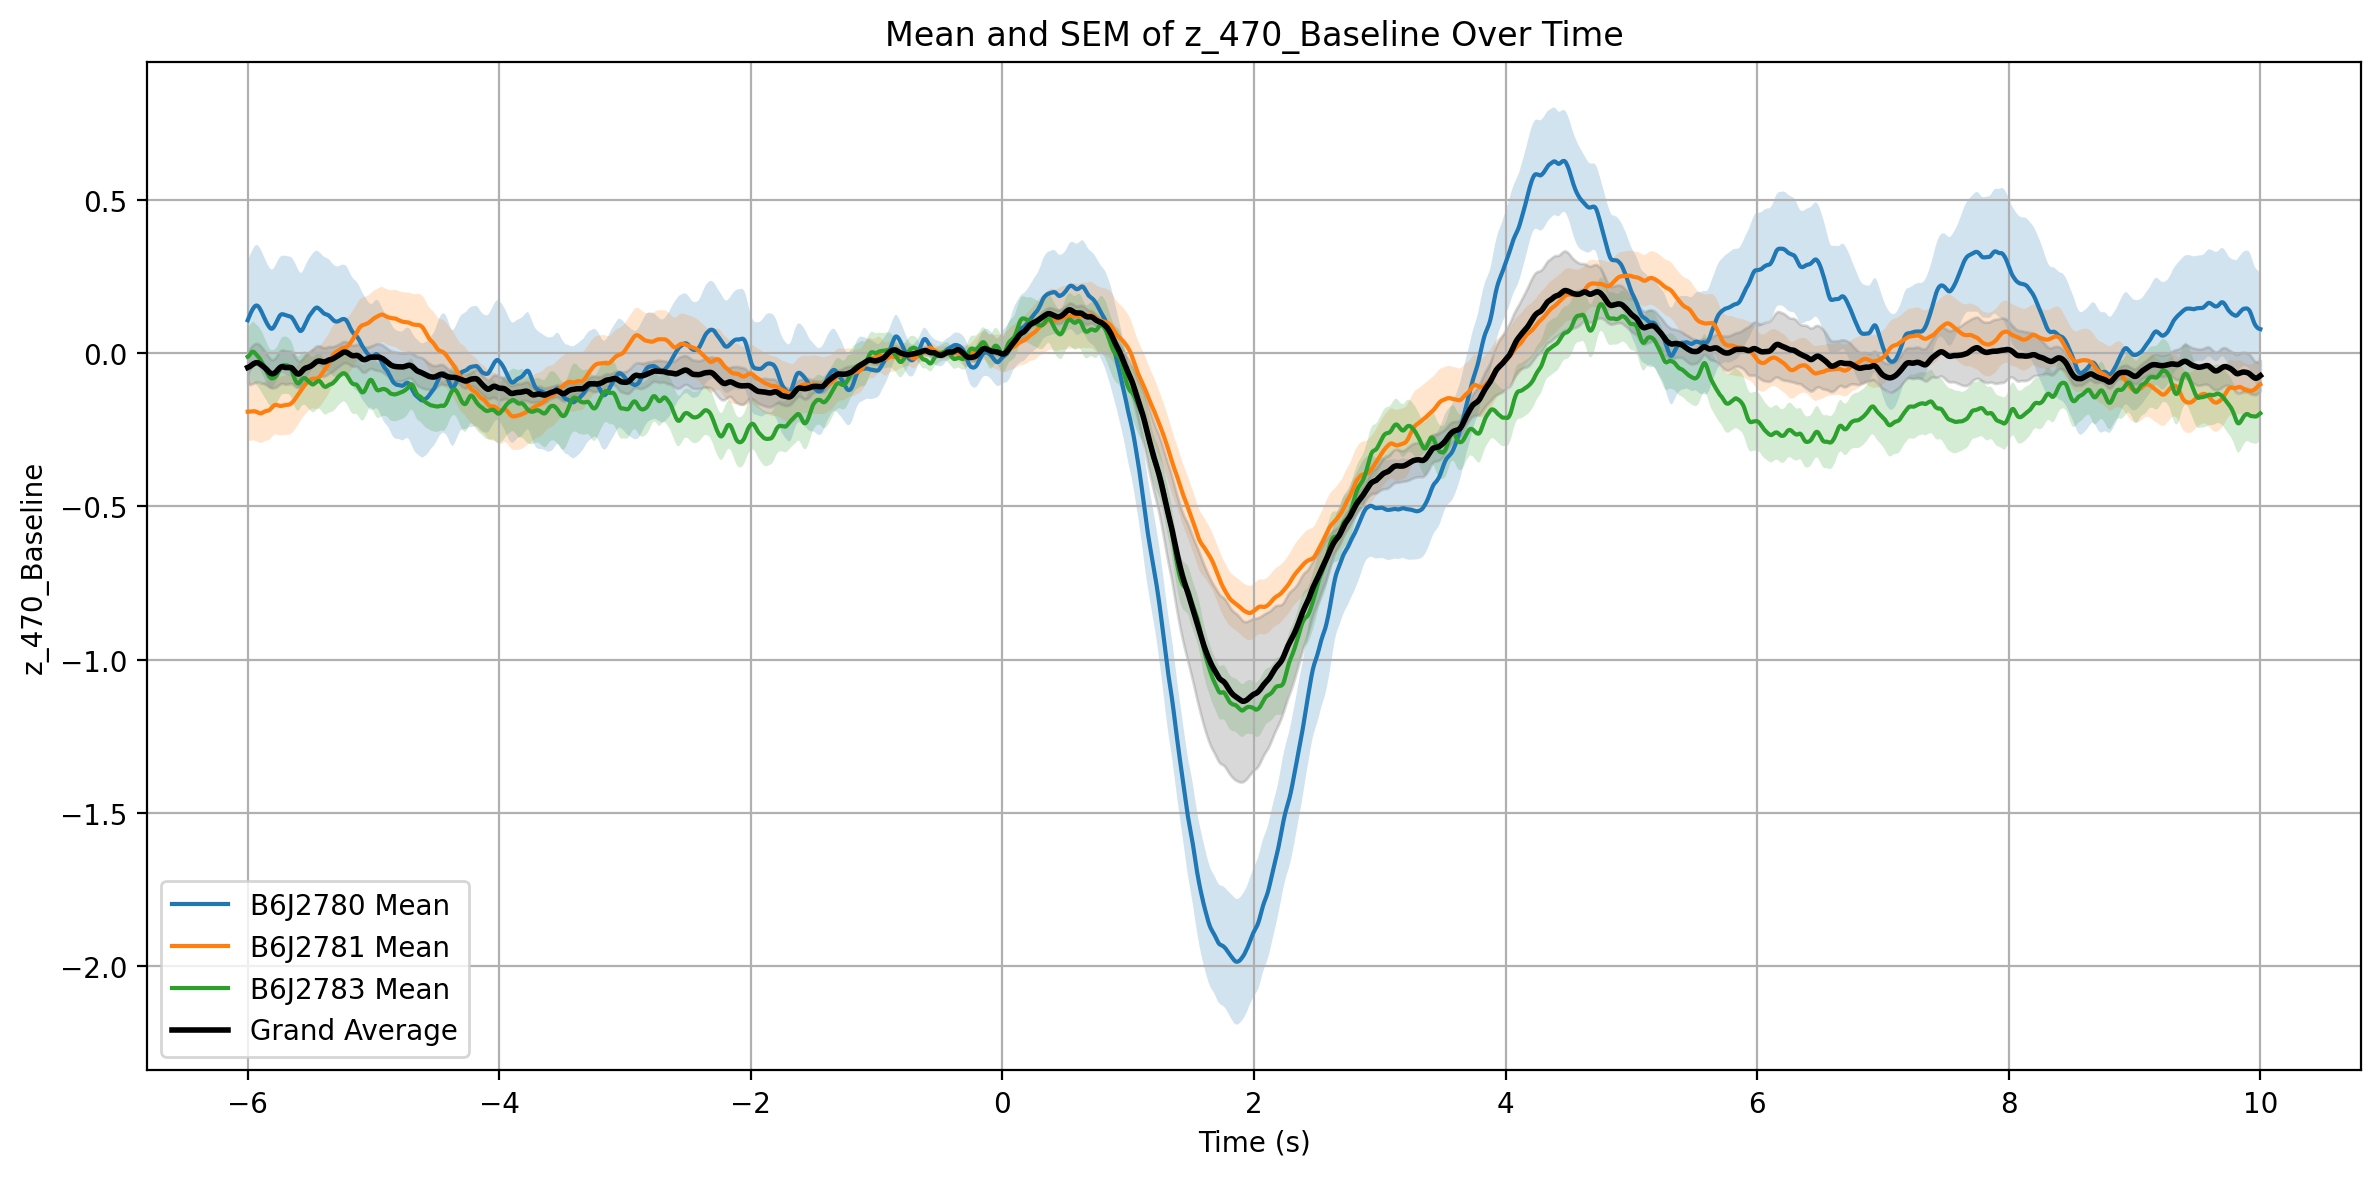

Plot saved to: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/z_560_Baseline_plot.pdf


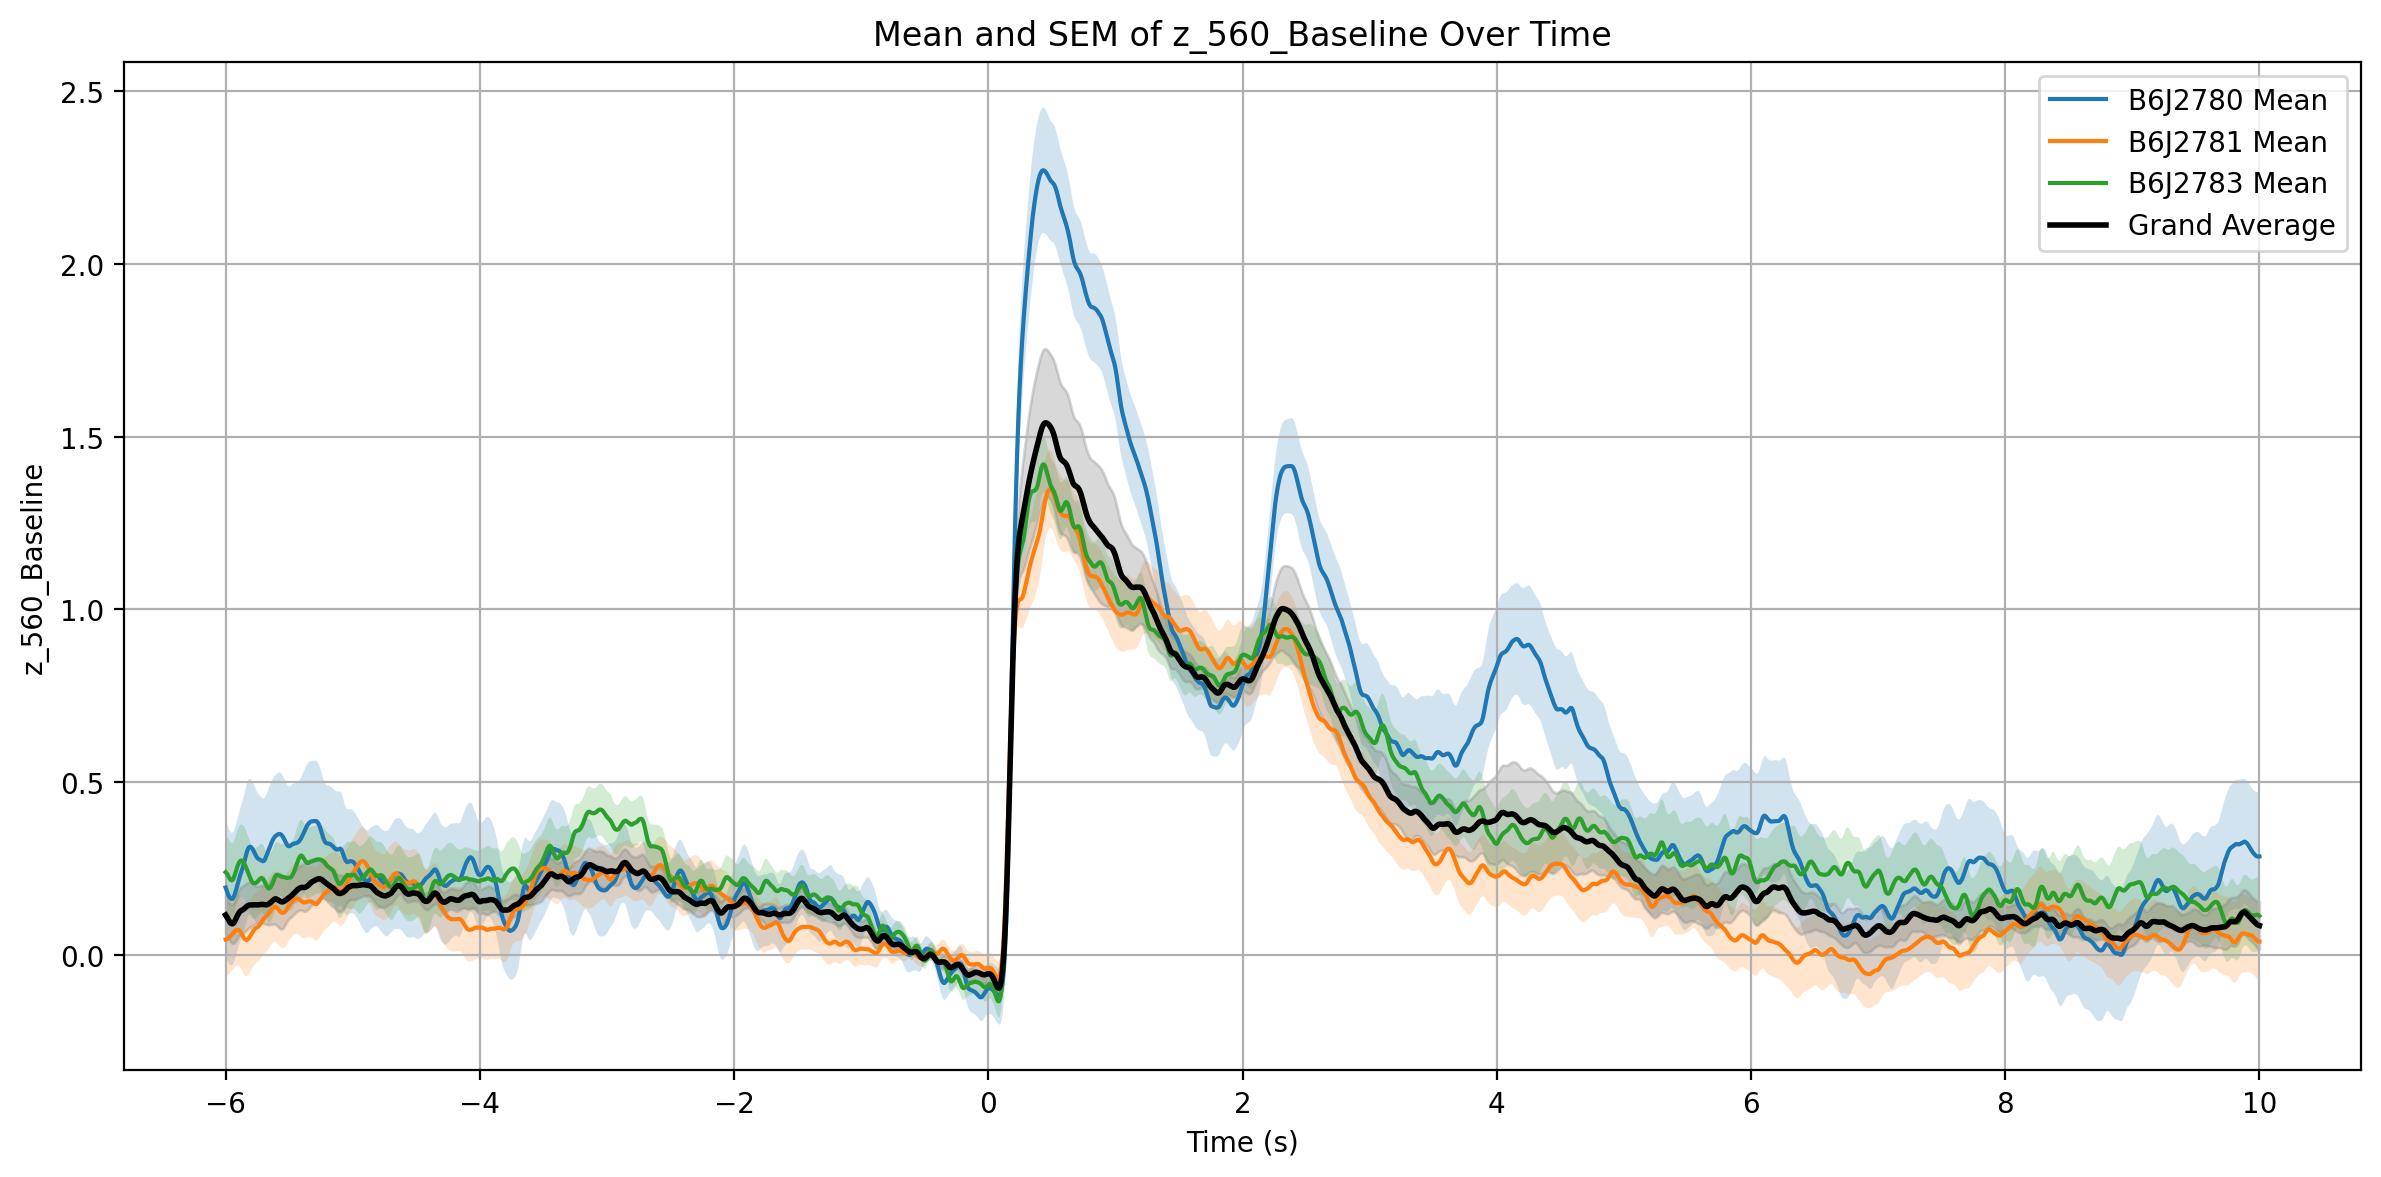

Plot saved to: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/Motor_Velocity_Baseline_plot.pdf


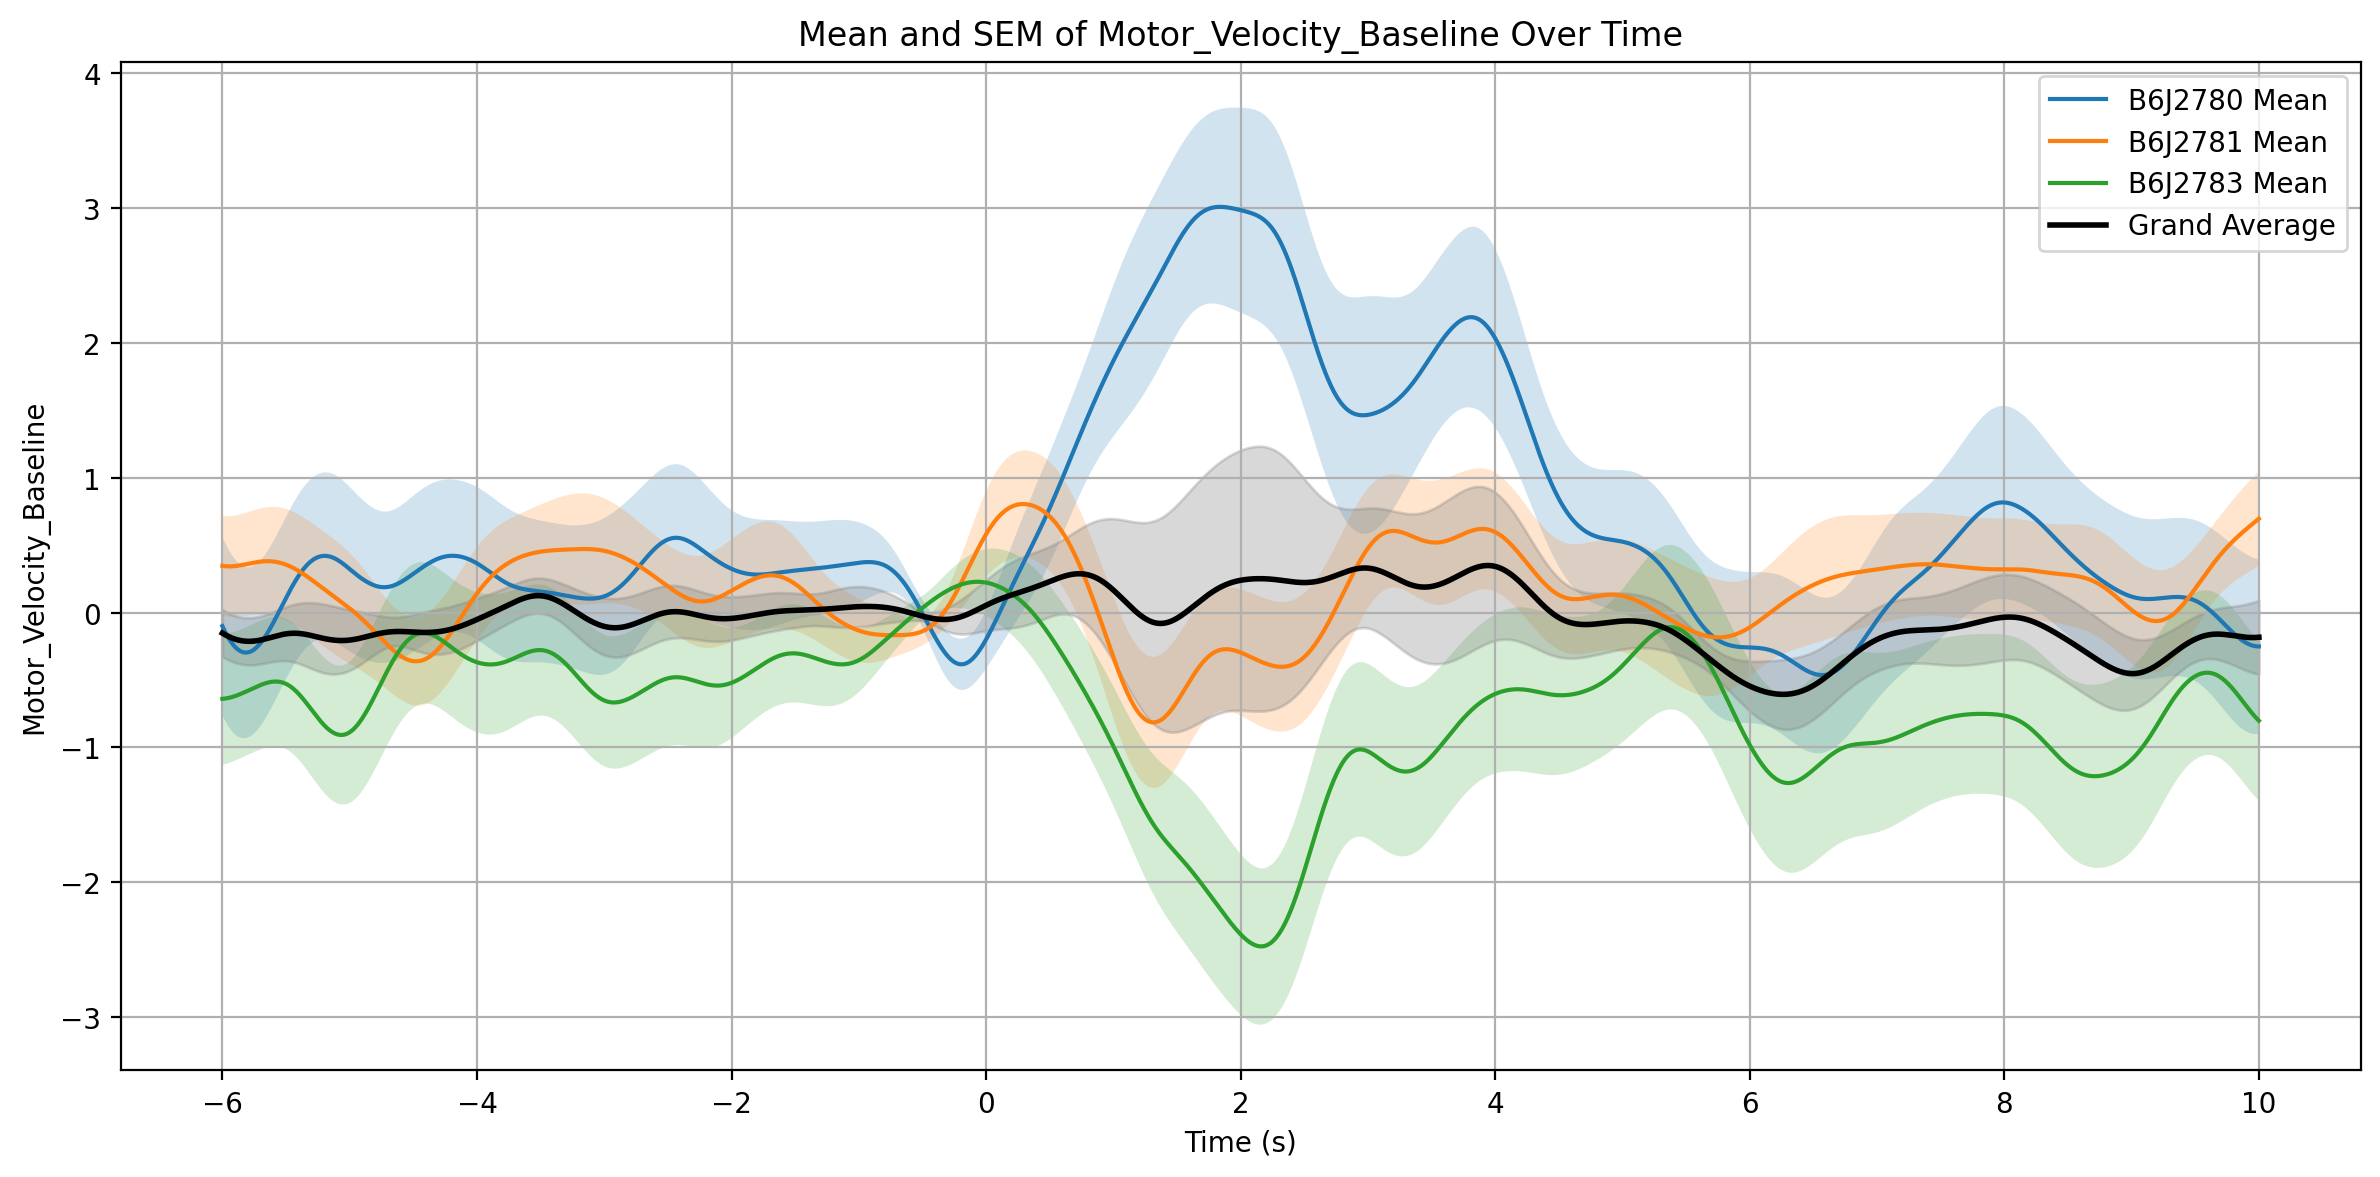

Plot saved to: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/Velocity_0Y_Baseline_plot.pdf


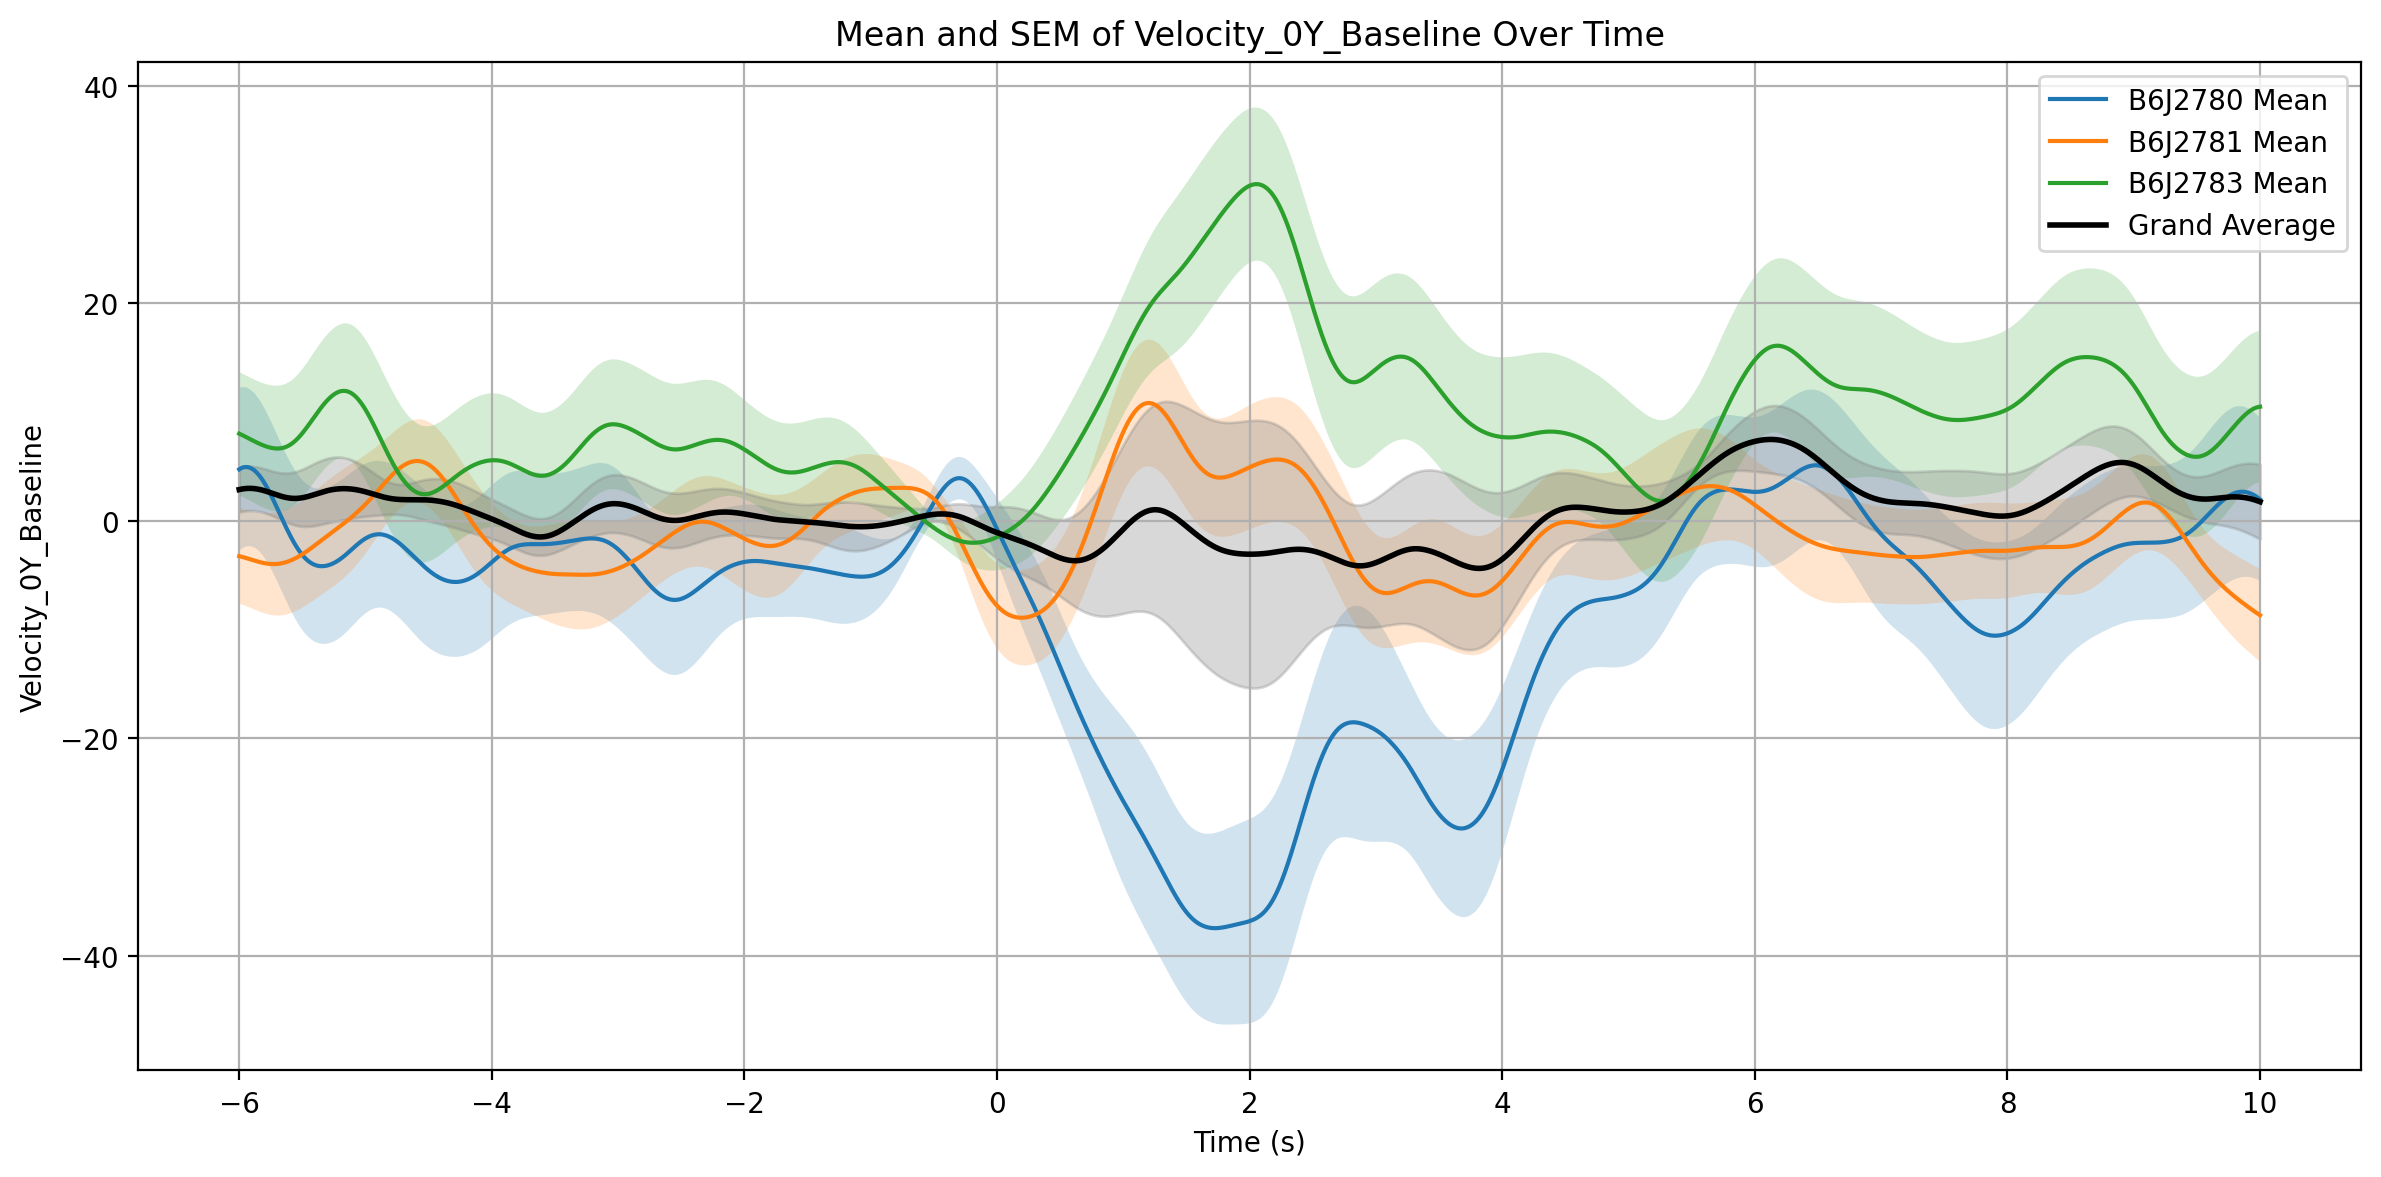

Plot saved to: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/Velocity_0X_Baseline_plot.pdf


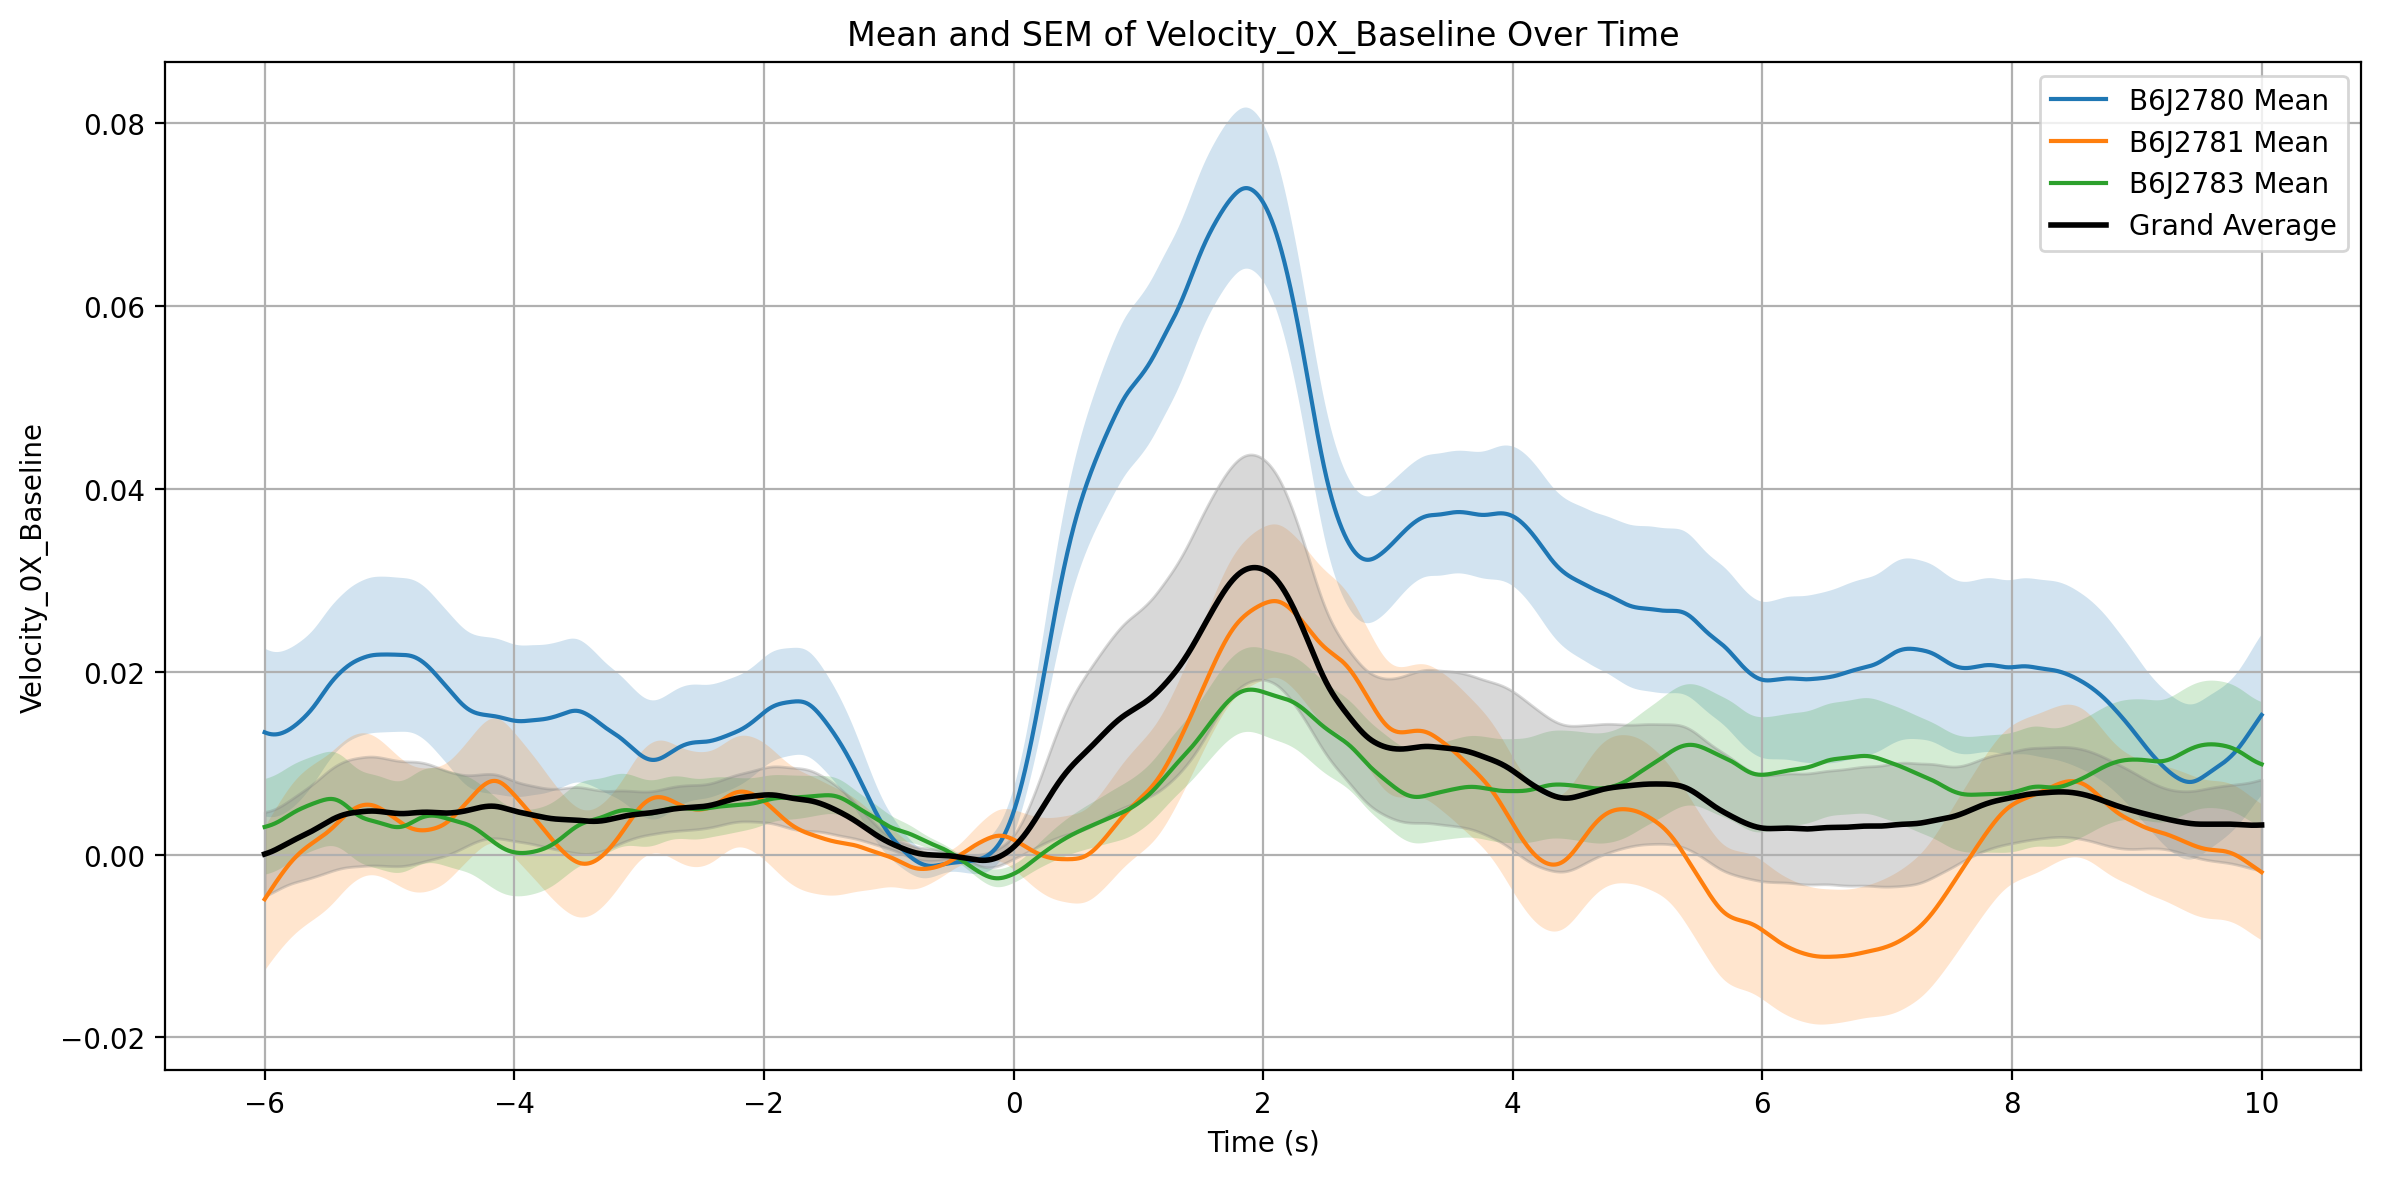

Grand averages with SEM saved to: /Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1/grand_averages_with_sem_B6J2780_B6J2781_B6J2783.csv


In [6]:
#select mice that you want to use to compute the grand average and to plot
# selected_mice = ['B6J2717', 'B6J2718', 'B6J2719', 'B6J2720', 'B6J2721', 'B6J2722']
selected_mice = selected_mice

# Define the column to plot the grand average of
columns_to_plot = ['z_470_Baseline', 'z_560_Baseline', 'Motor_Velocity_Baseline', 'Velocity_0Y_Baseline', 'Velocity_0X_Baseline']

for column_to_plot in columns_to_plot:
    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot mean and SEM for each selected mouse
    for mouse in selected_mice:
        if mouse in results['mean_data_per_mouse']:
            mean_data = pd.to_numeric(results['mean_data_per_mouse'][mouse][column_to_plot], errors='coerce')
            sem_data = pd.to_numeric(results['sem_data_per_mouse'][mouse][column_to_plot], errors='coerce')
            time_points = pd.to_numeric(mean_data.index, errors='coerce')

            # Plot mean with SEM as shaded area
            plt.plot(time_points, mean_data, label=f'{mouse} Mean')
            plt.fill_between(time_points, mean_data - sem_data, mean_data + sem_data, alpha=0.2)

    # Plot the grand average
    grand_mean = pd.to_numeric(results['grand_averages'][column_to_plot], errors='coerce')
    grand_sem = pd.to_numeric(results['grand_sems'][column_to_plot], errors='coerce')
    time_points = pd.to_numeric(grand_mean.index, errors='coerce')

    plt.plot(time_points, grand_mean, label='Grand Average', color='black', linewidth=2)
    plt.fill_between(time_points, grand_mean - grand_sem, grand_mean + grand_sem, color='gray', alpha=0.3)
    # Add labels, legend, and title
    plt.xlabel('Time (s)')
    plt.ylabel(column_to_plot)
    plt.title(f'Mean and SEM of {column_to_plot} Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot to the main directory
    plot_filename = main_data_dir / f"{column_to_plot}_plot.pdf"
    plt.savefig(plot_filename)
    print(f"Plot saved to: {plot_filename}")

    # Show the plot
    plt.show()

# Create a DataFrame combining grand averages and SEMs
grand_avg_with_sem = results['grand_averages'].copy()
for col in results['grand_sems'].columns:
    grand_avg_with_sem[f'{col}_SEM'] = results['grand_sems'][col]

# Generate a filename that includes the selected mice
mice_str = "_".join(selected_mice)
csv_filename = main_data_dir / f'grand_averages_with_sem_{mice_str}.csv'

# Save the DataFrame to a CSV file
grand_avg_with_sem.to_csv(csv_filename)
print(f"Grand averages with SEM saved to: {csv_filename}")

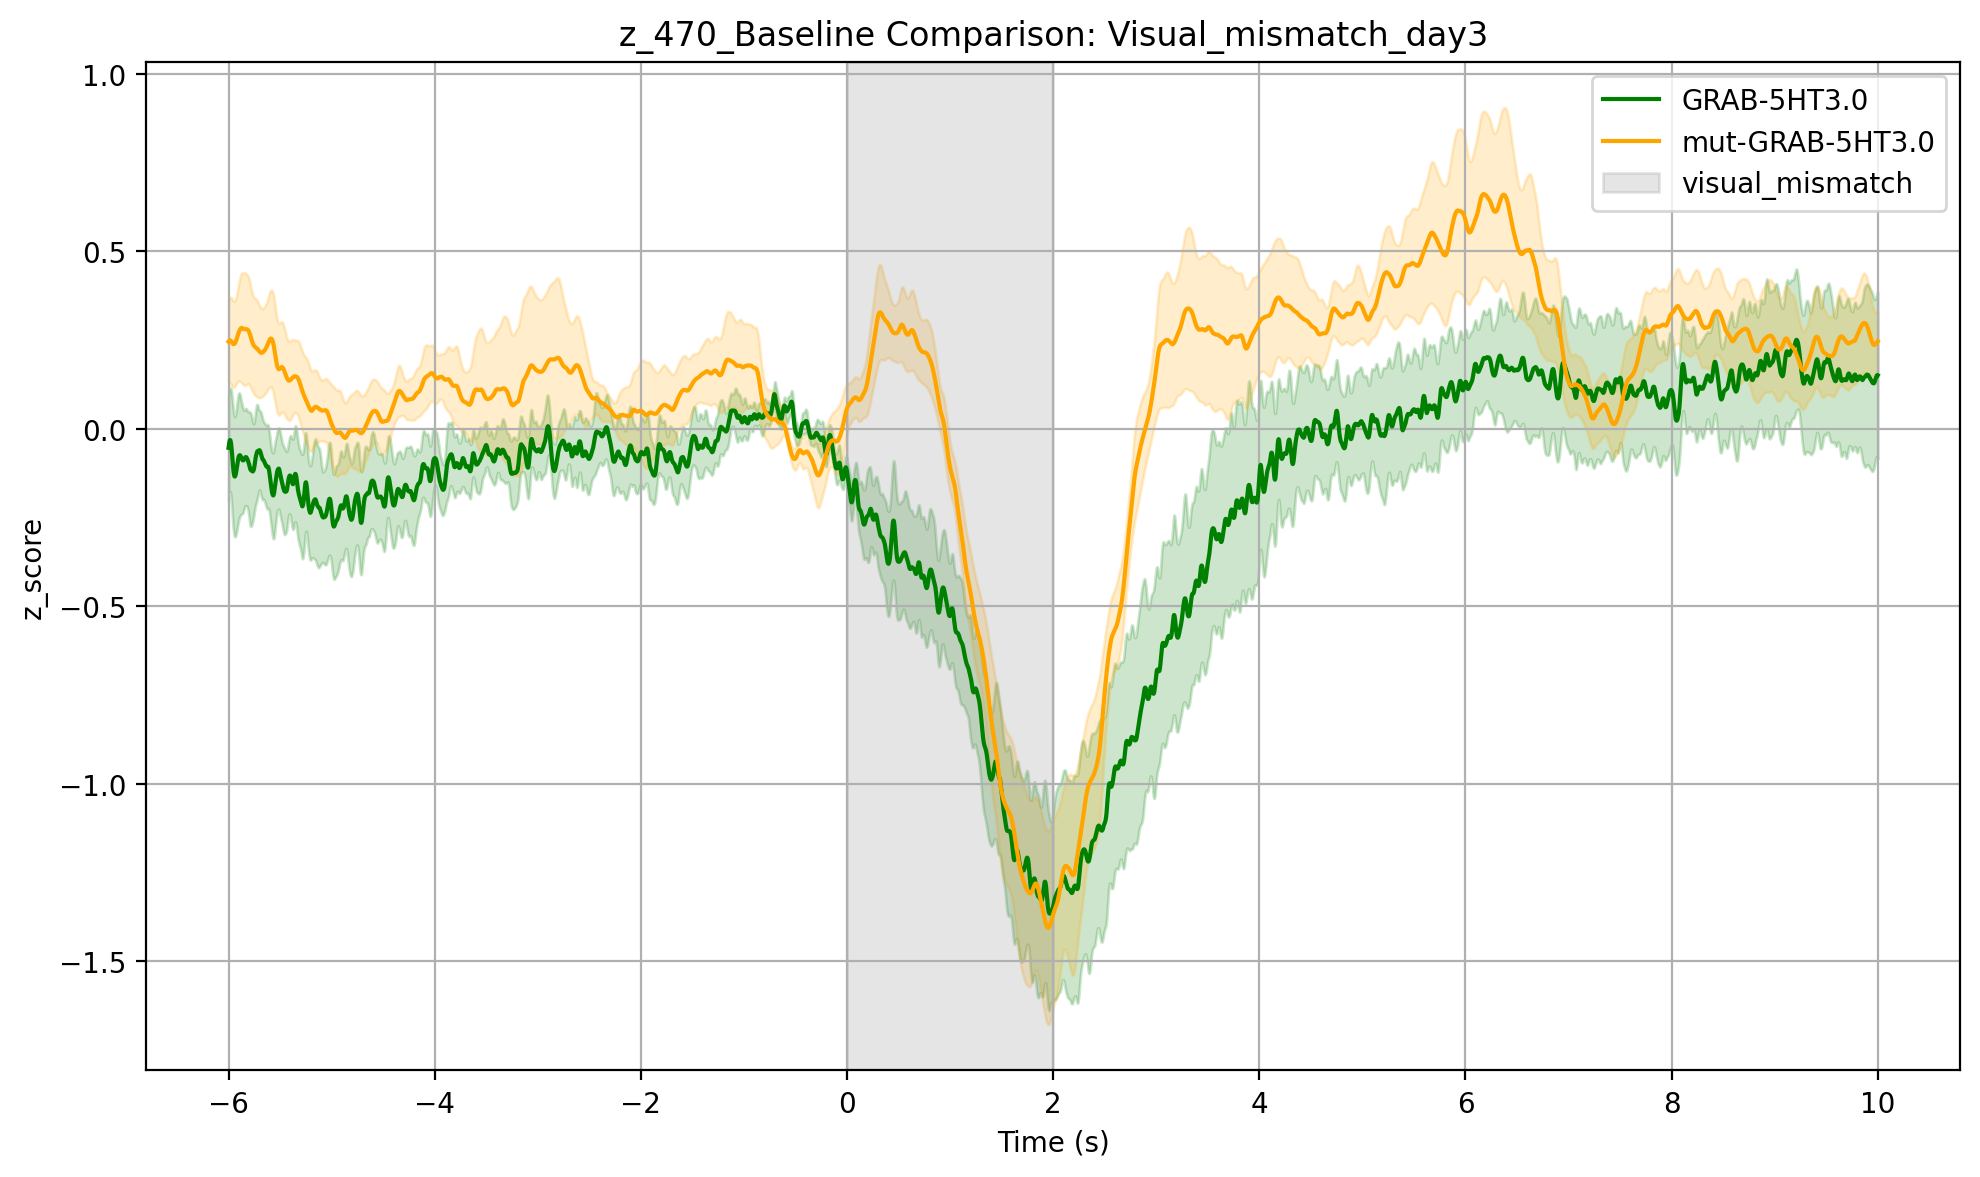

In [17]:
# Paths to your CSV files for the session 'Visual_mismatch_day3'
# Replace these with the actual paths to your files
vmm3_cohort1 = '/Volumes/RanczLab2/20241125_Cohort1_rotation/Visual_mismatch_day3/grand_averages_with_sem_B6J2717_B6J2718_B6J2719_B6J2720_B6J2721_B6J2722.csv'
vmm3_cohort3 = '/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3/grand_averages_with_sem_B6J2780_B6J2781_B6J2783.csv'
vmm4_cohort1 = '/Volumes/RanczLab2/20241125_Cohort1_rotation/Visual_mismatch_day4/grand_averages_with_sem_B6J2717_B6J2718_B6J2719_B6J2720_B6J2721_B6J2722.csv'
vmm4_cohort3 = '/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4/grand_averages_with_sem_B6J2780_B6J2781_B6J2783.csv'

# Load the data
df_cohort1 = pd.read_csv(vmm4_cohort1)
df_cohort3 = pd.read_csv(vmm4_cohort3)

# Plot the grand average and SEM for z_470_Baseline
plt.figure(figsize=(10, 6))

# Plot Cohort1
plt.plot(df_cohort1['Time (s)'], df_cohort1['z_470_Baseline'], label='GRAB-5HT3.0', color='green')
plt.fill_between(df_cohort1['Time (s)'],
                 df_cohort1['z_470_Baseline'] - df_cohort1['z_470_Baseline_SEM'],
                 df_cohort1['z_470_Baseline'] + df_cohort1['z_470_Baseline_SEM'],
                 color='green', alpha=0.2)

# Plot Cohort3
plt.plot(df_cohort3['Time (s)'], df_cohort3['z_470_Baseline'], label='mut-GRAB-5HT3.0', color='orange')
plt.fill_between(df_cohort3['Time (s)'],
                 df_cohort3['z_470_Baseline'] - df_cohort3['z_470_Baseline_SEM'],
                 df_cohort3['z_470_Baseline'] + df_cohort3['z_470_Baseline_SEM'],
                 color='orange', alpha=0.2)

# Add a gray shadowed area between seconds 0 and 2
plt.axvspan(0, 2, color='gray', alpha=0.2, label='visual_mismatch')

# Plot customization
plt.title('z_470_Baseline Comparison: Visual_mismatch_day3')
plt.xlabel('Time (s)')
plt.ylabel('z_score')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()
